In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n_samples = 1000

# Define latent factors with ecommerce interpretations:
# - Spending Power: influences Total Spending and Average Order Value.
# - Engagement: influences Number of Transactions, Browsing Time, and Last Purchase Days.
# - Loyalty: influences Account Age and Loyalty Points.
spending_power = np.random.normal(loc=50, scale=10, size=n_samples)
engagement     = np.random.normal(loc=5,  scale=1.5, size=n_samples)
loyalty        = np.random.normal(loc=3,  scale=1,   size=n_samples)

# Generate observed features as linear combinations of latent factors with added noise
total_spending    = spending_power * np.random.uniform(15, 25) + np.random.normal(scale=50, size=n_samples)
num_transactions  = np.clip(engagement * np.random.uniform(8, 12) + np.random.normal(scale=3, size=n_samples), 1, None)
avg_order_value   = spending_power * np.random.uniform(8, 12) + np.random.normal(scale=20, size=n_samples)
account_age       = np.clip(loyalty * np.random.uniform(2, 4) + np.random.normal(scale=0.5, size=n_samples), 0.5, None)
product_return_rate = np.clip(1 - (loyalty / 10) + np.random.normal(scale=0.05, size=n_samples), 0, 1)
discount_usage    = np.clip(np.random.uniform(0, 5, n_samples) + (60 - spending_power) / 10, 0, None)
last_purchase_days= np.clip(np.random.uniform(0, 365, n_samples) - engagement * np.random.uniform(10, 30), 1, 365)
browsing_time     = np.clip(engagement * np.random.uniform(5, 15) + np.random.normal(scale=5, size=n_samples), 1, None)
cart_abandonment_rate = np.clip(np.random.uniform(0, 1, n_samples) - engagement/20, 0, 1)
loyalty_points    = np.clip(loyalty * np.random.uniform(50, 100) + np.random.normal(scale=20, size=n_samples), 0, None)

spark = SparkSession.builder.appName("PCA Example").getOrCreate()

pdf = pd.DataFrame({
    'Total_Spending': total_spending,
    'Num_Transactions': num_transactions,
    'Average_Order_Value': avg_order_value,
    'Account_Age': account_age,
    'Product_Return_Rate': product_return_rate,
    'Discount_Usage': discount_usage,
    'Last_Purchase_Days': last_purchase_days,
    'Browsing_Time': browsing_time,
    'Cart_Abandonment_Rate': cart_abandonment_rate,
    'Loyalty_Points': loyalty_points,
})

df = spark.createDataFrame(pdf)
df.show(5)

+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+---------------------+------------------+
|    Total_Spending|  Num_Transactions|Average_Order_Value|       Account_Age|Product_Return_Rate|    Discount_Usage|Last_Purchase_Days|    Browsing_Time|Cart_Abandonment_Rate|    Loyalty_Points|
+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+---------------------+------------------+
|1271.2464926116093| 70.41810148175838|  546.3552975231466| 6.997678604209365| 0.8067770816129569|0.6625696596300675|  123.586667448723|98.77441924535418|   0.5443877512744528| 190.1876032892248|
|1149.8429927660459| 66.50012115664309| 490.57802546679875| 8.963680433028417| 0.6255678189530418|  3.48477928297122|203.13305687786212|95.88824925085376|   0.6505780473474858| 284.6372750088348|
|1288.0165266659899|

Explained Variance (all components): [0.28084003 0.24709884 0.21050663 0.09922404 0.0793697  0.05506384
 0.01574385 0.0046802  0.00390801 0.00356485]
Cumulative Explained Variance: [0.28084003 0.52793887 0.7384455  0.83766954 0.91703924 0.97210308
 0.98784693 0.99252714 0.99643515 1.        ]


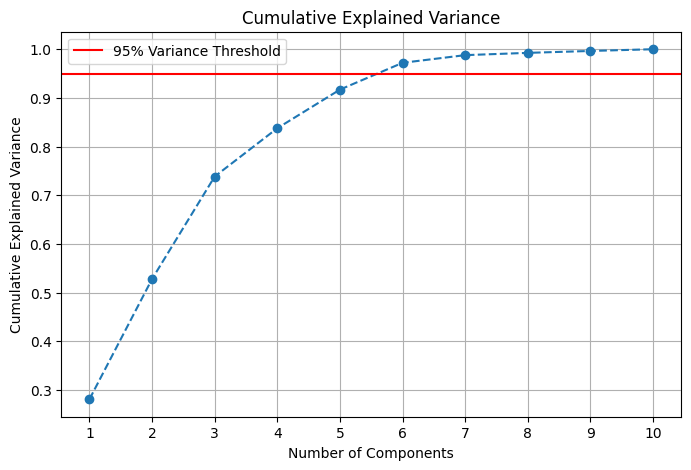

In [ ]:
input_cols = df.columns
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Use k = number of features to get full explained variance
pca_full = PCA(k=10, inputCol='scaled_features', outputCol='pca_features')
pipeline_full = Pipeline(stages=[assembler, scaler, pca_full])
model_full = pipeline_full.fit(df)
result_full = model_full.transform(df)

explained_variance = model_full.stages[-1].explainedVariance.toArray()
print("Explained Variance (all components):", explained_variance)

cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
n_components_95 = int(np.argmax(cumulative_variance >= 0.95) + 1)
print("Number of components to explain 95% variance:", n_components_95)

Number of components to explain 95% variance: 6


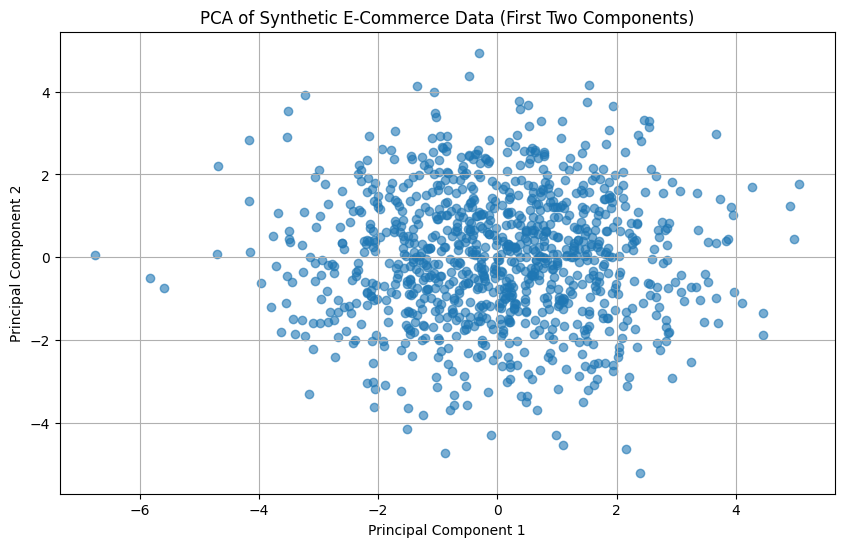

Explained variance by each selected component: [0.28084003477197744,0.2470988385082346,0.21050663124559,0.09922403619685684,0.0793697038549113,0.05506383600942761]


In [ ]:
pca_opt = PCA(k=n_components_95, inputCol='scaled_features', outputCol='pca_features_opt')
pipeline_opt = Pipeline(stages=[assembler, scaler, pca_opt])
model_opt = pipeline_opt.fit(df)
result_opt = model_opt.transform(df)

pca_df = result_opt.select("pca_features_opt").toPandas()
if n_components_95 >= 2:
    pca_df[['Principal Component 1', 'Principal Component 2']] = \
        pca_df['pca_features_opt'].apply(lambda x: pd.Series([float(x[0]), float(x[1])]))
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], alpha=0.6)
    plt.title('PCA of Synthetic E-Commerce Data (First Two Components)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()
else:
    print("Less than 2 components selected; cannot generate 2D plot.")

explained_variance_opt = model_opt.stages[-1].explainedVariance
print("Explained variance by each selected component:", explained_variance_opt)